# SDFusion: Text-guided Generation (txt2shape)

### TODO: add sample results or teaser images

In [2]:
!git clone https://github.com/ScheznikL/SDFusion.git
%cd SDFusion
!ls

Cloning into 'SDFusion'...
remote: Enumerating objects: 1958, done.
remote: Counting objects: 100% (99/99), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 1958 (delta 43), reused 81 (delta 34), pack-reused 1859 (from 1)
Receiving objects: 100% (1958/1958), 35.35 MiB | 24.11 MiB/s, done.
Resolving deltas: 100% (804/804), done.
/content/SDFusion
configs		    demo_img2shape.ipynb	  external   options	   train.py
dataset_info_files  demo_mm2shape.ipynb		  launchers  preprocess    utils
datasets	    demo_txt2shape.ipynb	  LICENSE    README.md
demo_data	    demo_uncond_shape_comp.ipynb  models     setup_env.sh


In [3]:
# first set up which gpu to use
import os
gpu_ids = 0
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_ids}"

In [7]:
#exit()
#How to run a Python script in a '.py' file from a Google Colab notebook?
from models.base_model import create_model

In [4]:
!pip install h5py joblib trimesh scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 704.8/704.8 kB 16.8 MB/s eta 0:00:00


In [5]:
!pip install --upgrade PyMCubes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.4/318.4 kB 7.7 MB/s eta 0:00:00


In [ ]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("2.1.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

  Cloning https://github.com/facebookresearch/pytorch3d.git (to revision stable) to /tmp/pip-req-build-_dbtu0pf
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/pytorch3d.git /tmp/pip-req-build-_dbtu0pf
  Running command git checkout -q 75ebeeaea0908c5527e7b1e305fbc7681382db47
  Resolved https://github.com/facebookresearch/pytorch3d.git to commit 75ebeeaea0908c5527e7b1e305fbc7681382db47
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [12]:
# import libraries
import numpy as np
from IPython.display import Image as ipy_image
from IPython.display import display
from termcolor import colored, cprint

import torch
import torch.backends.cudnn as cudnn
cudnn.benchmark = True
import torchvision.utils as vutils

from models.base_model import create_model
from utils.util_3d import render_sdf, render_mesh, sdf_to_mesh, save_mesh_as_gif

%load_ext autoreload
%autoreload 2

# New section

In [14]:
!pip install omegaconf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 5.5 MB/s eta 0:00:00
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144555 sha256=0480fe1b0252a449f784f6e315ff8dfeb4f8d2e7fe4b14d68956b07b6736fcb6
  Stored in directory: /root/.cache/pip/wheels/12/93/dd/1f6a127edc45659556564c5730f6d4e300888f4bca2d4c5a88
Successfully built antlr4-python3-runtime


In [15]:
# options for the model. please check `utils/demo_util.py` for more details
from utils.demo_util import SDFusionText2ShapeOpt

seed = 2023
opt = SDFusionText2ShapeOpt(gpu_ids=gpu_ids, seed=seed)
device = opt.device

[*] SDFusionText2ShapeOption initialized.


In [19]:
!mkdir saved_ckpt

In [20]:
# SDFusion: text-guided shape generation (txt2shape)
!wget https://uofi.box.com/shared/static/vyqs6aex3rwbgxweyl3qh21c8p6vu33f.pth -O saved_ckpt/sdfusion-txt2shape.pth

--2025-01-05 20:28:48--  https://uofi.box.com/shared/static/vyqs6aex3rwbgxweyl3qh21c8p6vu33f.pth
Resolving uofi.box.com (uofi.box.com)... 74.112.186.157
Connecting to uofi.box.com (uofi.box.com)|74.112.186.157|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/vyqs6aex3rwbgxweyl3qh21c8p6vu33f.pth [following]
--2025-01-05 20:28:48--  https://uofi.box.com/public/static/vyqs6aex3rwbgxweyl3qh21c8p6vu33f.pth
Reusing existing connection to uofi.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://uofi.app.box.com/public/static/vyqs6aex3rwbgxweyl3qh21c8p6vu33f.pth [following]
--2025-01-05 20:28:48--  https://uofi.app.box.com/public/static/vyqs6aex3rwbgxweyl3qh21c8p6vu33f.pth
Resolving uofi.app.box.com (uofi.app.box.com)... 74.112.186.157
Connecting to uofi.app.box.com (uofi.app.box.com)|74.112.186.157|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://public.boxcl

In [22]:
# VQVAE's checkpoint
!wget https://uofi.box.com/shared/static/zdb9pm9wmxaupzclc7m8gzluj20ja0b6.pth -O saved_ckpt/vqvae-snet-all.pth

--2025-01-05 20:32:15--  https://uofi.box.com/shared/static/zdb9pm9wmxaupzclc7m8gzluj20ja0b6.pth
Resolving uofi.box.com (uofi.box.com)... 74.112.186.157
Connecting to uofi.box.com (uofi.box.com)|74.112.186.157|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/zdb9pm9wmxaupzclc7m8gzluj20ja0b6.pth [following]
--2025-01-05 20:32:15--  https://uofi.box.com/public/static/zdb9pm9wmxaupzclc7m8gzluj20ja0b6.pth
Reusing existing connection to uofi.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://uofi.app.box.com/public/static/zdb9pm9wmxaupzclc7m8gzluj20ja0b6.pth [following]
--2025-01-05 20:32:15--  https://uofi.app.box.com/public/static/zdb9pm9wmxaupzclc7m8gzluj20ja0b6.pth
Resolving uofi.app.box.com (uofi.app.box.com)... 74.112.186.157
Connecting to uofi.app.box.com (uofi.app.box.com)|74.112.186.157|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://public.boxcl

In [23]:
# initialize SDFusion model
ckpt_path = 'saved_ckpt/sdfusion-txt2shape.pth'
opt.init_model_args(ckpt_path=ckpt_path)

SDFusion = create_model(opt)
cprint(f'[*] "{SDFusion.name()}" loaded.', 'cyan')

Working with z of shape (1, 3, 16, 16, 16) = 12288 dimensions.
[*] VQVAE: weight successfully load from: saved_ckpt/vqvae-snet-all.pth


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/content/SDFusion/models/sdfusion_txt2shape_model.py:567: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(ckpt, map_location=map_fn)


[*] weight successfully load from: saved_ckpt/sdfusion-txt2shape.pth
[*] setting ddim_steps=100
[*] Model has been created: SDFusion-Text2Shape-Model
[*] "SDFusion-Text2Shape-Model" loaded.


## SDFusion: text-guided generation (txt2shape)

Data shape for DDIM sampling is (6, 3, 16, 16, 16), eta 0.0
Running DDIM Sampling with 100 timesteps


DDIM Sampler: 100%|██████████| 100/100 [03:08<00:00,  1.89s/it]


Input: "A rocking chair"


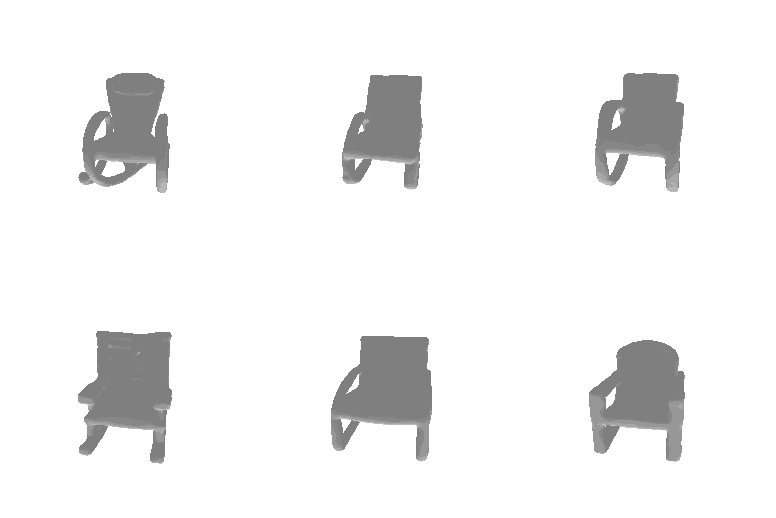

In [26]:
from pytorch3d.io import save_obj, save_ply

# txt2shape
out_dir = 'demo_results'
if not os.path.exists(out_dir): os.makedirs(out_dir)

# change the input text here to generate different chairs/tables!
input_txt = "A rocking chair"

ngen = 6 # number of generated shapes
ddim_steps = 100
ddim_eta = 0.
uc_scale = 3.

sdf_gen = SDFusion.txt2shape(input_txt=input_txt, ngen=ngen, ddim_steps=ddim_steps, ddim_eta=ddim_eta, uc_scale=uc_scale)

mesh_gen = sdf_to_mesh(sdf_gen)

# Save meshes to .obj and/or .ply
for i, mesh in enumerate(mesh_gen):
    verts, faces = mesh.verts_packed(), mesh.faces_packed()
    # Save to .obj format
    obj_path = f"{out_dir}/shape_{i}_{input_txt.replace(' ', '_')}.obj"
    save_obj(obj_path, verts, faces)
    print(f"Saved OBJ to {obj_path}")

# vis as gif
gen_name = f'{out_dir}/txt2shape-{input_txt}.gif'
save_mesh_as_gif(SDFusion.renderer, mesh_gen, nrow=3, out_name=gen_name)

print(f'Input: "{input_txt}"')
for name in [gen_name]:
    display(ipy_image(name))

In [ ]:
from pytorch3d.io import IO

device=torch.device("cuda:0")
mesh = IO().load_mesh("mymesh.obj", device=device)

pcl = Pointclouds(...)
IO().save_pointcloud(pcl, "output_pointcloud.ply")